# Практическая работа 3: Анализ данных авиакомпаний

## Задание 13
**Цель:** Найти топ-3 стран-производителей по общей выручке от проданных автомобилей на основе консолидации данных из трех источников:
- **manufacturers.csv** — данные о производителях (`brand_id`, `brand_name`, `country`)
- **models.xlsx** — данные о моделях (`model_name`, `brand_id`, `price`)
- **sales.json** — данные о продажах (`model_name`, `units_sold`)

## Библиотеки и подключения


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✓ Библиотеки загружены")


✓ Библиотеки загружены


## 1. Загрузка данных из различных источников


In [8]:
# Загрузка данных о производителях(CSV)
df_manufacturers = pd.read_csv('data/manufacturers.csv')
print("Данные о производителях(CSV):")
print(f"Форма данных: {df_manufacturers.shape}")
print(df_manufacturers.head())
print("\n" + "="*50 + "\n")


Данные о производителях(CSV):
Форма данных: (30, 3)
  brand_id     brand_name   country
0    BR001            BMW  Германия
1    BR002  Mercedes-Benz  Германия
2    BR003           Audi  Германия
3    BR004        Porsche  Германия
4    BR005     Volkswagen  Германия




In [9]:
# Загрузка данных о моделях (Excel)
df_models = pd.read_excel('data/models.xlsx')
print("Данные о моделях(Excel):")
print(f"Форма данных: {df_models.shape}")
print(df_models.head())
print("\n" + "="*50 + "\n")


Данные о моделях(Excel):
Форма данных: (100, 3)
                 model_name brand_id     price
0           BMW Comfort-350    BR001   4780000
1             BMW Hatch-792    BR001  10080000
2   Mercedes-Benz Beast-132    BR002   2800000
3  Mercedes-Benz Saloon-338    BR002   7670000
4           Audi Ranger-833    BR003   9150000




In [10]:
# Загрузка данных о продажах(JSON)
with open('data/sales.json', 'r', encoding='utf-8') as f:
    sales_data = json.load(f)

df_sales = pd.DataFrame(sales_data)
print("Данные о продажах(JSON):")
print(f"Форма данных: {df_sales.shape}")
print(df_sales.head())
print("\n" + "="*50 + "\n")


Данные о продажах(JSON):
Форма данных: (100, 2)
                 model_name  units_sold
0           BMW Comfort-350        2427
1             BMW Hatch-792        1411
2   Mercedes-Benz Beast-132        1317
3  Mercedes-Benz Saloon-338        2385
4           Audi Ranger-833        1732




## 2. Консолидация данных и расчет выручки


In [14]:
# Объединение всех данных
# Шаг 1: Объединение моделей с производителями
df_models_manufacturers = pd.merge(df_models, df_manufacturers, on='brand_id', how='inner')


# Шаг 2: Объединение с данными о продажах
df_consolidated = pd.merge(df_models_manufacturers, df_sales, on='model_name', how='inner')

# Расчет выручки для каждой модели
df_consolidated['model_revenue'] = df_consolidated['price'] * df_consolidated['units_sold']

print("Консолидированные данные:")
print(f"Форма данных: {df_consolidated.shape}")
print(df_consolidated[['model_name', 'brand_name', 'country', 'price', 'units_sold', 'model_revenue']].head())


# Расчет общей выручки по странам
country_revenue = df_consolidated.groupby('country').agg({
    'model_revenue': 'sum',           
    'model_name': 'nunique',          
    'units_sold': 'sum',              
    'price': 'mean'                   
}).round(2)

country_revenue.columns = ['total_revenue', 'num_models', 'total_units_sold', 'avg_price']
country_revenue = country_revenue.sort_values('total_revenue', ascending=False)


print("\n" + "="*70)
print("ОБЩАЯ ВЫРУЧКА ПО СТРАНАМ-ПРОИЗВОДИТЕЛЯМ")
print("="*70)
print(country_revenue)

Консолидированные данные:
Форма данных: (100, 7)
                 model_name     brand_name   country     price  units_sold  \
0           BMW Comfort-350            BMW  Германия   4780000        2427   
1             BMW Hatch-792            BMW  Германия  10080000        1411   
2   Mercedes-Benz Beast-132  Mercedes-Benz  Германия   2800000        1317   
3  Mercedes-Benz Saloon-338  Mercedes-Benz  Германия   7670000        2385   
4           Audi Ranger-833           Audi  Германия   9150000        1732   

   model_revenue  
0    11601060000  
1    14222880000  
2     3687600000  
3    18292950000  
4    15847800000  

ОБЩАЯ ВЫРУЧКА ПО СТРАНАМ-ПРОИЗВОДИТЕЛЯМ
                total_revenue  num_models  total_units_sold   avg_price
country                                                                
Япония           222412820000          22             58263  3681818.18
США              153015940000          19             29349  5110000.00
Германия         123416610000          

## 3. Визуализация результатов


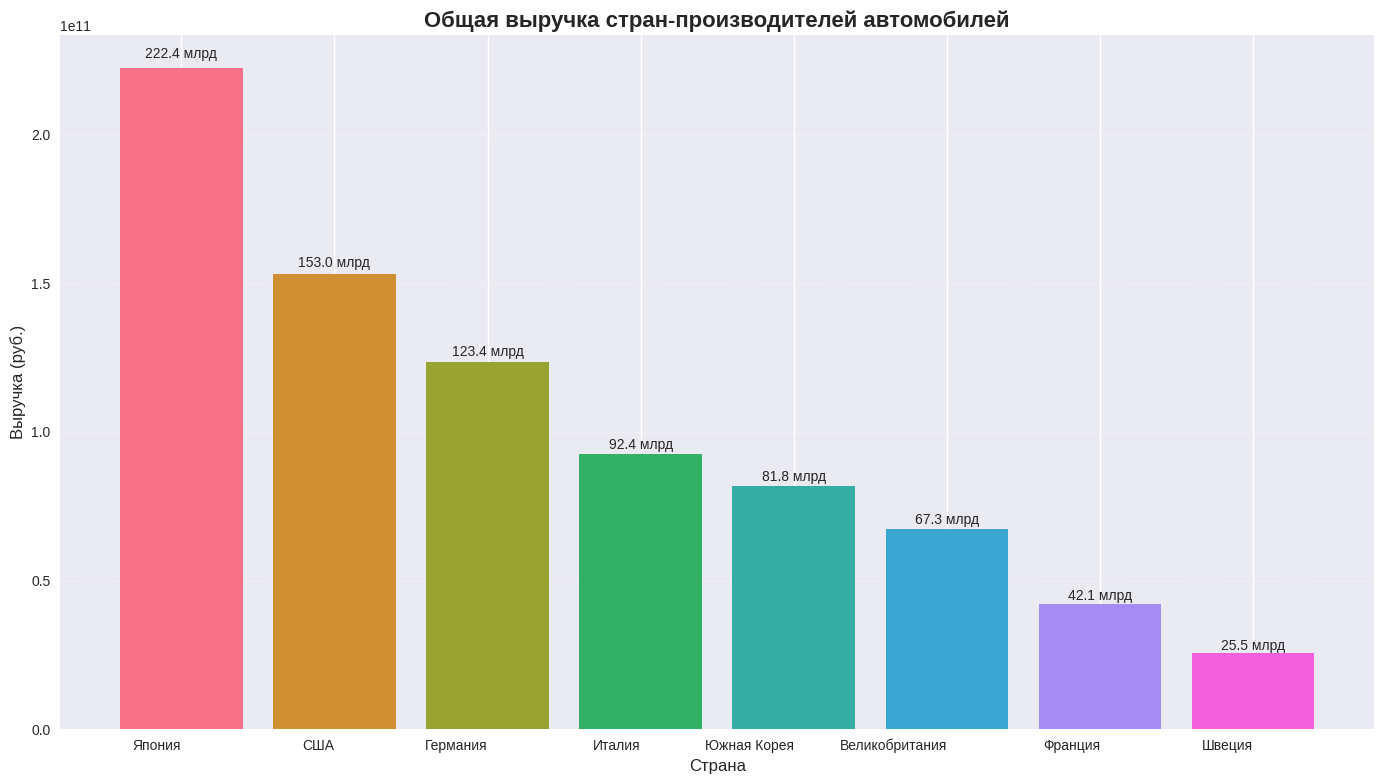

In [15]:
# График 1: Общая выручка производителей
country_revenue = country_revenue.sort_values('total_revenue', ascending=False)

plt.figure(figsize=(14, 8))


bars = plt.bar(
    range(len(country_revenue)), 
    country_revenue['total_revenue'], 
    color=sns.color_palette("husl", len(country_revenue))  
)

plt.title('Общая выручка стран-производителей автомобилей', fontsize=16, fontweight='bold')
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Выручка (руб.)', fontsize=12)


plt.xticks(
    range(len(country_revenue)), 
    country_revenue.index, 
    ha='right'  
)

for i, bar in enumerate(bars):
    height = bar.get_height()
    # Форматируем число: 1,000,000,000 → "1.0 млрд"
    if height >= 1e9:
        label = f'{height / 1e9:.1f} млрд'
    elif height >= 1e6:
        label = f'{height / 1e6:.0f} млн'
    else:
        label = f'{height:,.0f}'
    
    plt.text(
        bar.get_x() + bar.get_width() / 2., 
        height + height * 0.01,  
        label, 
        ha='center', 
        va='bottom', 
        fontsize=10,
        fontweight='normal'
    )

plt.tight_layout()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()


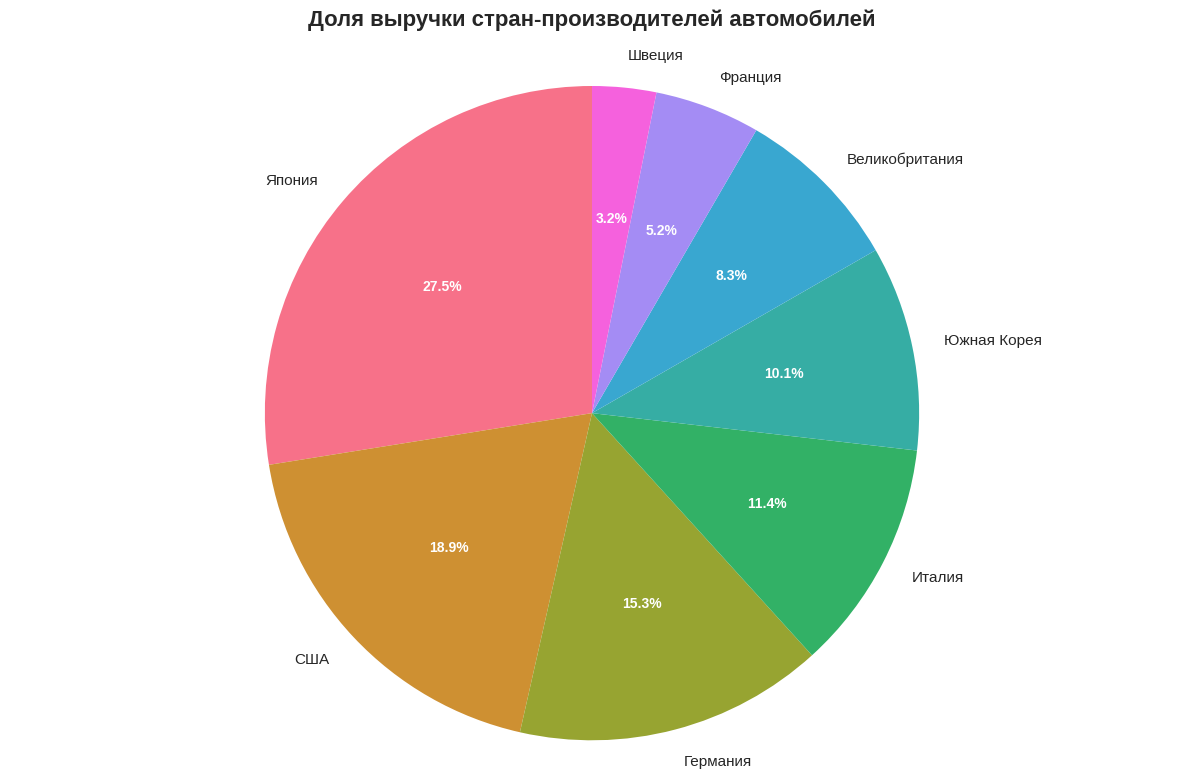

In [16]:
# График 2: Круговая диаграмма доли выручки
plt.figure(figsize=(12, 8))


colors = sns.color_palette("husl", len(country_revenue))


wedges, texts, autotexts = plt.pie(
    country_revenue['total_revenue'],
    labels=country_revenue.index,  
    autopct='%1.1f%%',            
    colors=colors,
    startangle=90,               
    textprops={'fontsize': 11}    
)

plt.title('Доля выручки стран-производителей автомобилей', 
          fontsize=16, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)


plt.axis('equal')
plt.tight_layout()
plt.show()


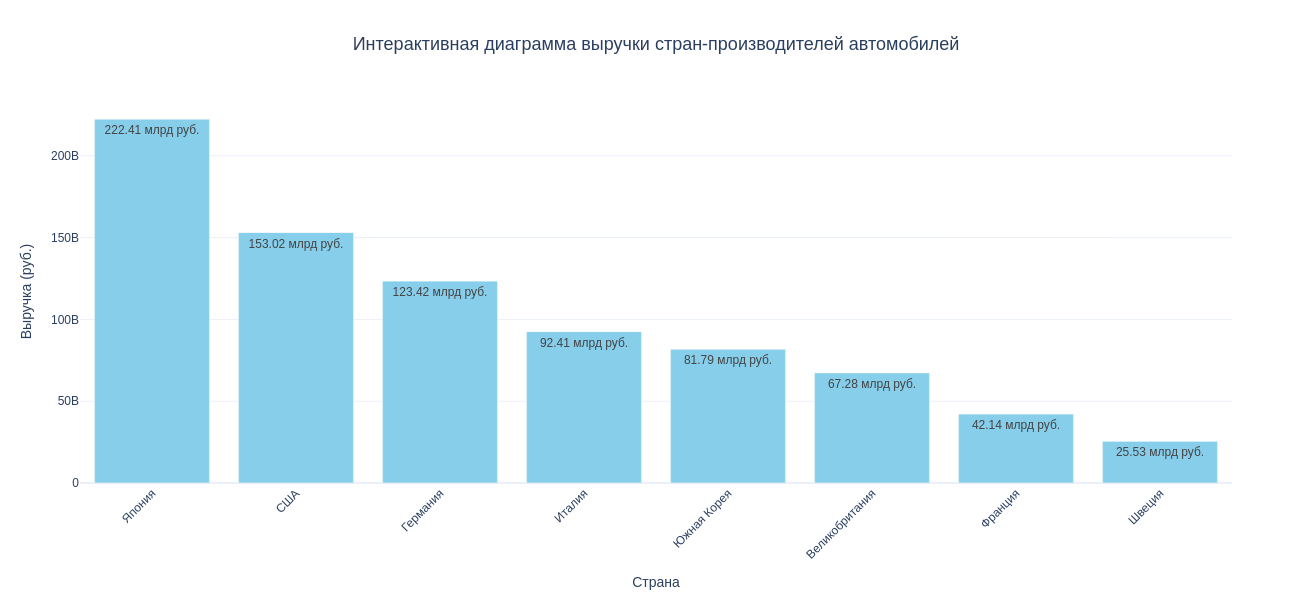

In [17]:
# График 3: Интерактивная визуализация с Plotly
fig = go.Figure()


fig.add_trace(go.Bar(
    x=country_revenue.index,  
    y=country_revenue['total_revenue'],
    name='Выручка',
    marker_color='skyblue',  # Красивый цвет
    text=[f'{value / 1e9:.2f} млрд руб.' if value >= 1e9 else f'{value / 1e6:.1f} млн руб.' 
          for value in country_revenue['total_revenue']],  
    textposition='auto',
    hovertemplate=(
        '<b>Страна:</b> %{x}<br>' +
        '<b>Выручка:</b> %{y:,.0f} руб.<br>' +
        '<b>Доля:</b> %{customdata:.1f}%<extra></extra>'
    ),
    customdata=(country_revenue['total_revenue'] / country_revenue['total_revenue'].sum() * 100) 
))


fig.update_layout(
    title={
        'text': 'Интерактивная диаграмма выручки стран-производителей автомобилей',
        'font': {'size': 18, 'family': 'Arial, sans-serif'},
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Страна',
    yaxis_title='Выручка (руб.)',
    showlegend=False,
    height=600,
    xaxis_tickangle=-45,  
    template='plotly_white'  
)


fig.show()


## 4. Выводы и сохранение результатов


In [20]:
# Формирование выводов и сохранение результатов
print("ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА")
print("=" * 70)

# Ключевые метрики
top_country = country_revenue.index[0]
top_revenue = country_revenue.iloc[0]['total_revenue']
total_market_revenue = country_revenue['total_revenue'].sum()
market_share = (top_revenue / total_market_revenue) * 100


print(f"1. Лидер среди производителей: {top_country}")
print(f"   - Общая выручка: {top_revenue:,.0f} руб.")
print(f"   - Доля рынка: {market_share:.1f}%")

print(f"\n2. Общий объём рынка (суммарная выручка): {total_market_revenue:,.0f} руб.")
print(f"3. Количество стран-производителей: {len(country_revenue)}")
print(f"4. Средняя выручка на страну: {country_revenue['total_revenue'].mean():,.0f} руб.")

## Топ-3 страны по выручке
top3_countries = country_revenue.head(3)
print("\n" + " ТОП-3 СТРАНЫ ПО ВЫРУЧКЕ:")
for idx, (country, row) in enumerate(top3_countries.iterrows(), 1):
    print(f"{idx}. {country} — {row['total_revenue']:,} руб. "
          f"(продано авто: {int(row['total_units_sold']):,}, моделей: {int(row['num_models'])})")

# Сохранение результатов
df_consolidated.to_csv('data/consolidated_car_data.csv', index=False)
country_revenue.to_csv('data/country_revenue_summary.csv')

print("\n" + "=" * 70)
print("✓ Результаты сохранены в папке 'data/'")
print("✓ Анализ завершен успешно!")


ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА
1. Лидер среди производителей: Япония
   - Общая выручка: 222,412,820,000 руб.
   - Доля рынка: 27.5%

2. Общий объём рынка (суммарная выручка): 807,993,540,000 руб.
3. Количество стран-производителей: 8
4. Средняя выручка на страну: 100,999,192,500 руб.

 ТОП-3 СТРАНЫ ПО ВЫРУЧКЕ:
1. Япония — 222,412,820,000.0 руб. (продано авто: 58,263, моделей: 22)
2. США — 153,015,940,000.0 руб. (продано авто: 29,349, моделей: 19)
3. Германия — 123,416,610,000.0 руб. (продано авто: 20,355, моделей: 14)

✓ Результаты сохранены в папке 'data/'
✓ Анализ завершен успешно!
